# Visualization

In [1]:

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import ScalarFormatter

import data_processing
import feature_extraction

# Plot all data

In [2]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)
#df = dp.drop_unlabelled(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [3]:
df = data_processing.create_segments(df)

Group data to visualize each trajectory

In [4]:
segment = df.groupby('segment')

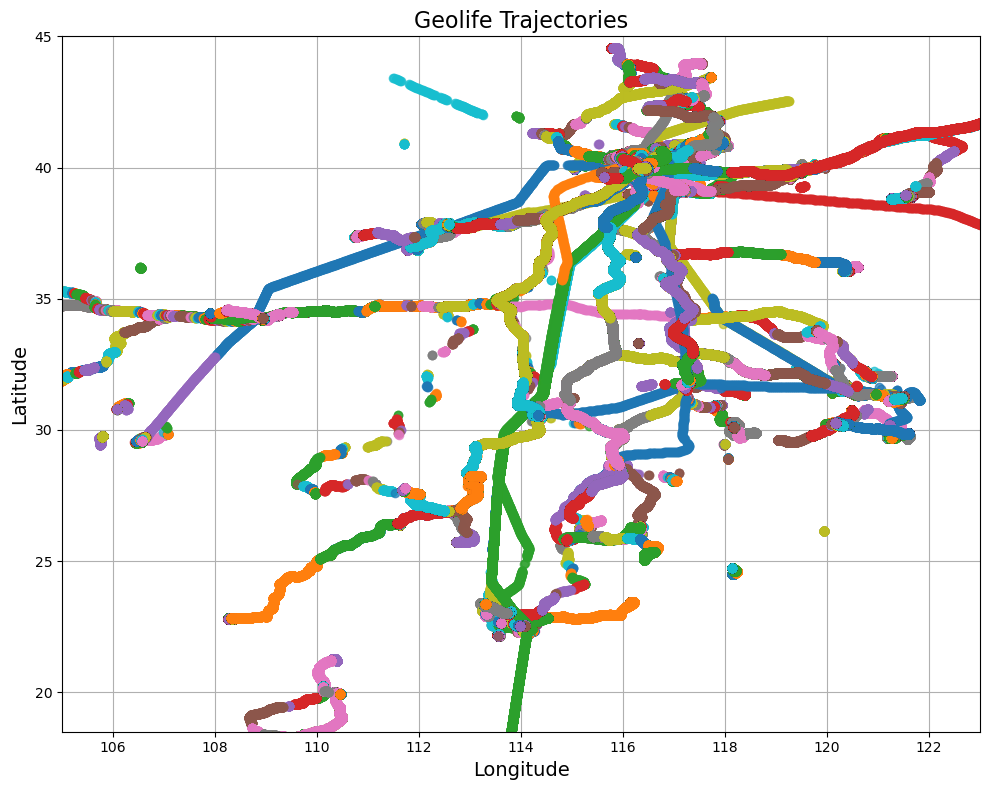

In [58]:
plt.figure(figsize=(10, 8))
plt.title("Geolife Trajectories", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(105, 123)  # Longitude limits
plt.ylim(18.5, 45)  # Latitude limits

# Plot each trajectory
for name, group in segment:
    plt.plot(group['lon'], group['lat'], 'o',alpha=0.7)

# Add a legend
#plt.legend(title="Trajectory File", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.grid()

# Save the plot as a file
plt.savefig("geolife_trajectories23.png", dpi=50)

# Show the plot
plt.show()


In [9]:
from pyproj import Transformer

# Create a transformer object
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

# Example: Transform a single point (longitude, latitude)
lon, lat = 132, 45  # Example coordinates in degrees
x, y = transformer.transform(lon, lat)  # Transformed coordinates in meters
print(f"Transformed coordinates: x = {x}, y = {y}")

Transformed coordinates: x = 14694172.784712112, y = 5621521.486192066


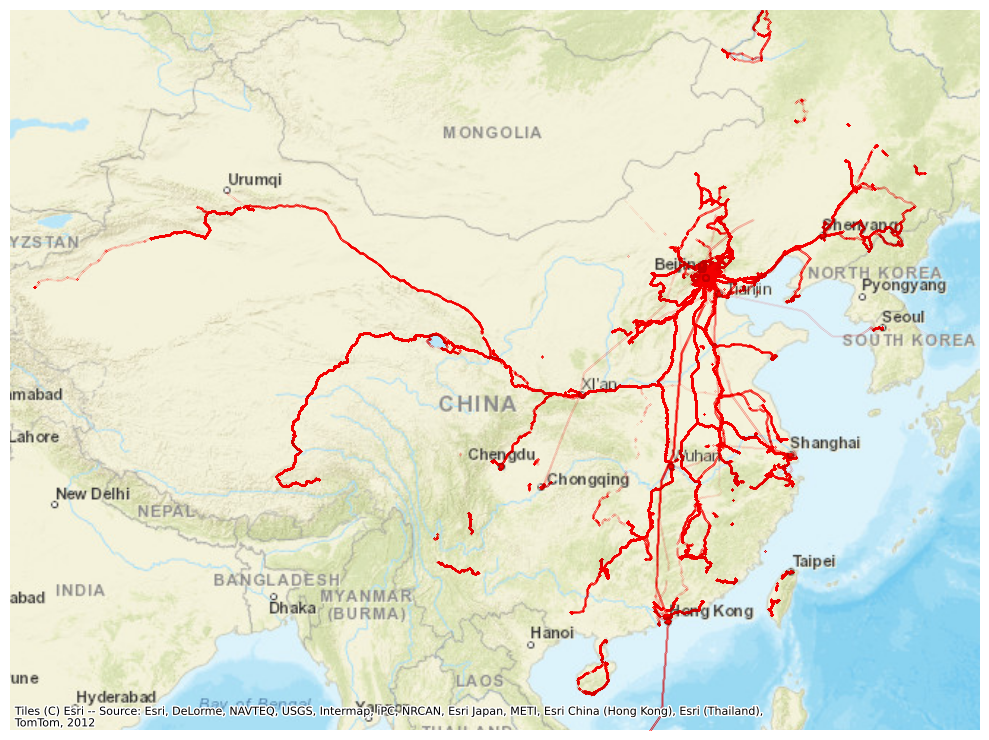

In [ ]:
gdfs = []
for name, group in segment:
    gdf = gpd.GeoDataFrame(group, geometry=gpd.points_from_xy(group['lon'], group['lat']), crs="EPSG:4326")
    gdfs.append(gdf)

all_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")

# Convert to Web Mercator
all_gdf = all_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))


ax.scatter(all_gdf.geometry.x, all_gdf.geometry.y, alpha=0.2, color='red', s=0.003)

ax.set_xlim(8296156.5384662861, 14794172.784712112)
ax.set_ylim(1822943.445786067, 6646863.140106901)
ax.set_aspect('equal')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axis('off')  


ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)

plt.tight_layout()
plt.grid(False) 
plt.savefig("Graphs/geolife_datapints_china.png", dpi=100)
plt.show()



In [4]:
df = data_processing.calculations(df)

Add filter

In [8]:
def filter_entire_trajectories(
    df: pd.DataFrame,
    max_speed_kmh: float = 150,
    max_distance_km: float = 0.5,
    segment_col: str = 'segment'
) -> pd.DataFrame:
    """
    Remove entire trajectories where ANY point exceeds specified thresholds.

    Parameters:
    - df: DataFrame containing trajectory data with:
        - 'speed' (in km/s - ensure this matches your calculation units)
        - 'distance' (in km between consecutive points)
    - max_speed_kmh: Maximum allowed speed in km/h (converted to km/s internally)
    - max_distance_km: Maximum allowed distance between consecutive points in km
    - segment_col: Column name identifying unique trajectories

    Returns:
    - DataFrame containing only complete trajectories where ALL points:
        - Speed ≤ max_speed_kmh 
        - Distance ≤ max_distance_km

    Example:
    >>> df_clean = filter_entire_trajectories(raw_data, 150, 0.5)
    """
    # Input validation
    if 'speed' not in df.columns or 'distance' not in df.columns:
        raise ValueError("DataFrame must contain 'speed' and 'distance' columns")
    
    if segment_col not in df.columns:
        raise ValueError(f"Segment column '{segment_col}' not found in DataFrame")

    # Convert speed threshold from km/h to km/s
    threshold_km_per_sec = max_speed_kmh / 3600

    # Identify segments with any violations
    violation_mask = (
        (df['speed'] > threshold_km_per_sec) |
        (df['distance'] > max_distance_km)
    )
    
    # Get list of bad segments with ANY violations
    bad_segments = df.loc[violation_mask, segment_col].unique()
    
    # Filter out all points from bad segments
    clean_df = df[~df[segment_col].isin(bad_segments)].copy()
    
    return clean_df.reset_index(drop=True)

In [7]:
df = filter_entire_trajectories(df)

NameError: name 'filter_entire_trajectories' is not defined

Plot all data in Beijing

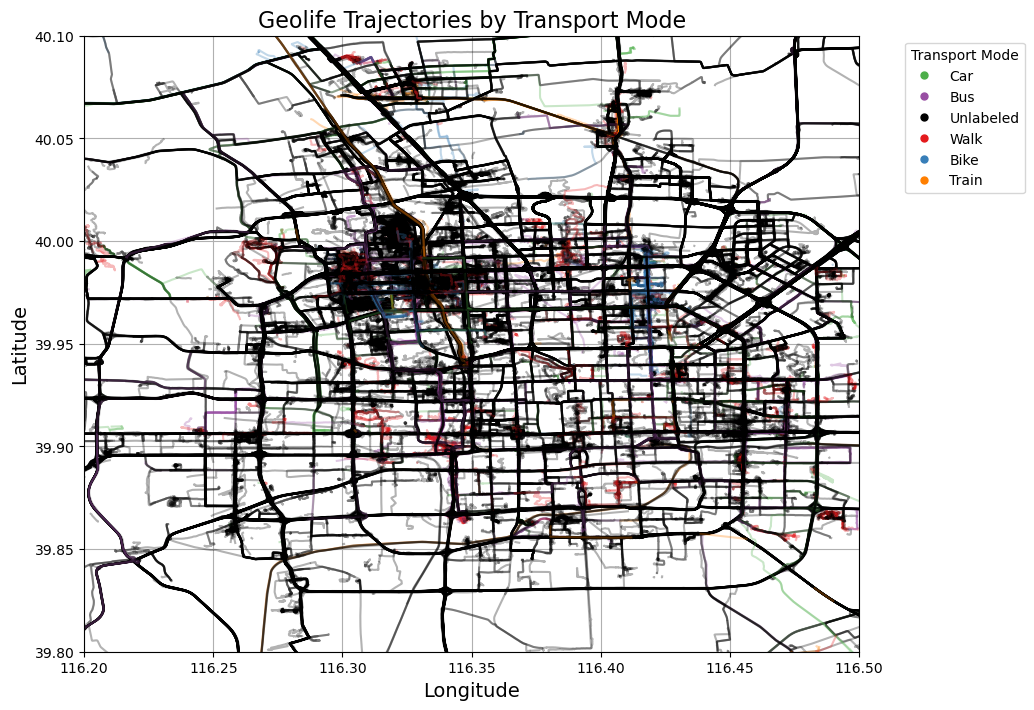

In [ ]:
color_map = {
    'walk': color_palette[0],   # Soft Green
    'bike': color_palette[1],   # Light Orange
    'car': color_palette[2],    # Light Blue
    'bus': color_palette[3],    # Light Purple
    'train': color_palette[4],  # Teal
    '0': 'black'                 # Explicit gray for unlabeled
}

plt.figure(figsize=(10, 8))
plt.title("Geolife Trajectories by Transport Mode", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116.2, 116.5)
plt.ylim(39.8, 40.1)

# Track unique transport modes for legend
unique_labels = set()

# Iterate over each segment and plot it with the corresponding color
for name, group in segment:
    transport_mode = str(group['label'].iloc[0])  # Convert to string
    color = color_map.get(transport_mode, 'black')  # Now '0' will get gray
    plt.plot(group['lon'], group['lat'], color=color, alpha=0.2)
    unique_labels.add(transport_mode)

# Create legend with proper labels and colors
handles = []
labels = []
for label in unique_labels:
    display_label = "Unlabeled" if label == '0' else label.capitalize()
    handles.append(plt.Line2D([0], [0], 
                    color=color_map[label], 
                    marker='o',
                    linestyle='None',
                    markersize=5))
    labels.append(display_label)

plt.legend(handles, labels, 
           title="Transport Mode", 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           fontsize=10)

plt.grid()
plt.savefig("Graphs/geolife_unlabeled.png", 
            dpi=500, 
            bbox_inches="tight")
plt.show()

Plot prediced data

In [2]:
loaded_df = pd.read_pickle("updated_df_fifteen_predicted_merged.pkl")

In [3]:
loaded_df

label  segment     speed  acceleration  angular_acceleration  \
0          bike      3.0  0.001383      0.883825              0.499991   
1          bike      3.0  0.002172      0.883840              0.500009   
2          bike      3.0  0.013209      0.883905              0.499972   
3          bike      3.0  0.001552      0.883824              0.499996   
4          bike      4.0  0.001684      0.883703              0.499445   
...         ...      ...       ...           ...                   ...   
13478904  train  54149.6  0.313134      0.884145              0.506254   
13478905  train  54149.6  0.327655      0.884841              0.496202   
13478906  train  54149.6  0.310766      0.881509              0.515073   
13478907  train  54149.6  0.297862      0.882949              0.494912   
13478908  train  54149.6  0.152360      0.873801              0.497486   

                 lon        lat  distance  
0         116.330383  39.976200  0.011390  
1         116.330367  39.976033  0.018587  
2         116.330300  39.975817  0.024753  
3         116.330333  39.975700  0.013280  
4         116.330667  39.975383  0.011390  
...              ...        ...       ...  
13478904  129.063237  44.633498  0.025512  
13478905  129.062910  44.633918  0.053391  
13478906  129.062783  44.634127  0.025319  
13478907  129.062502  44.634515  0.048536  
13478908  129.062357  44.634713  0.024827  

[17555291 rows x 8 columns]

In [4]:
segment = loaded_df.groupby('segment')

In [13]:
loaded_df =data_processing.filter(loaded_df)

In [11]:
loaded_df = filter_entire_trajectories(loaded_df)

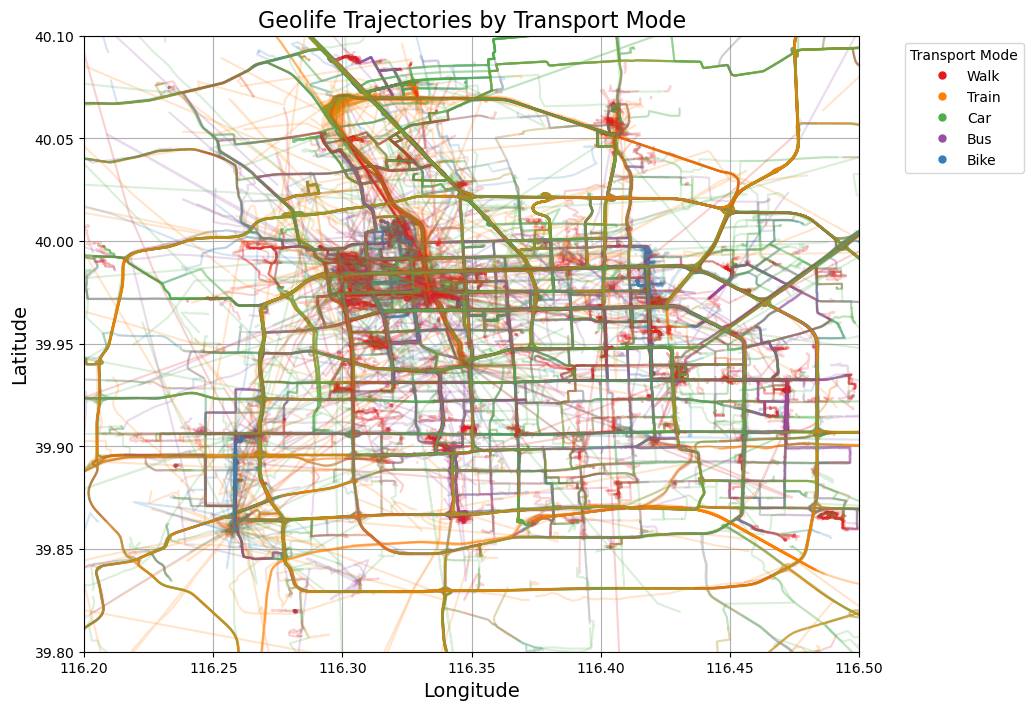

In [28]:
color_palette = sns.color_palette("Set1", 8)
color_map = {
    'walk': color_palette[0],   # Soft Green
    'bike': color_palette[1],   # Light Orange
    'car': color_palette[2],    # Light Blue
    'bus': color_palette[3],    # Light Purple
    'train': color_palette[4],  # Teal
    '0': 'black'                 # Explicit gray for unlabeled
}

plt.figure(figsize=(10, 8))
plt.title("Geolife Trajectories by Transport Mode", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116.2, 116.5)
plt.ylim(39.8, 40.1)

# Track unique transport modes for legend
unique_labels = set()

# Iterate over each segment and plot it with the corresponding color
for name, group in segment:
    transport_mode = str(group['label'].iloc[0])  # Convert to string
    color = color_map.get(transport_mode, 'black')  # Now '0' will get gray
    plt.plot(group['lon'], group['lat'], color=color, alpha=0.2)
    unique_labels.add(transport_mode)

# Create legend with proper labels and colors
handles = []
labels = []
for label in unique_labels:
    display_label = "Unlabeled" if label == '0' else label.capitalize()
    handles.append(plt.Line2D([0], [0], 
                    color=color_map[label], 
                    marker='o',
                    linestyle='None',
                    markersize=5))
    labels.append(display_label)

plt.legend(handles, labels, 
           title="Transport Mode", 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           fontsize=10)

plt.grid()
plt.savefig("Graphs/geolife_trajectories_predicted.png", 
            dpi=500, 
            bbox_inches="tight")
plt.show()

# Plot labeled data

In [ ]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)
df = data_processing.drop_unlabelled(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [ ]:
df = data_processing.create_segments(df)

In [11]:
segment = df.groupby('segment')

In [8]:
print(df['label'].value_counts())

label
walk     1585401
bus      1276632
bike      948061
train     847147
car       754825
Name: count, dtype: int64


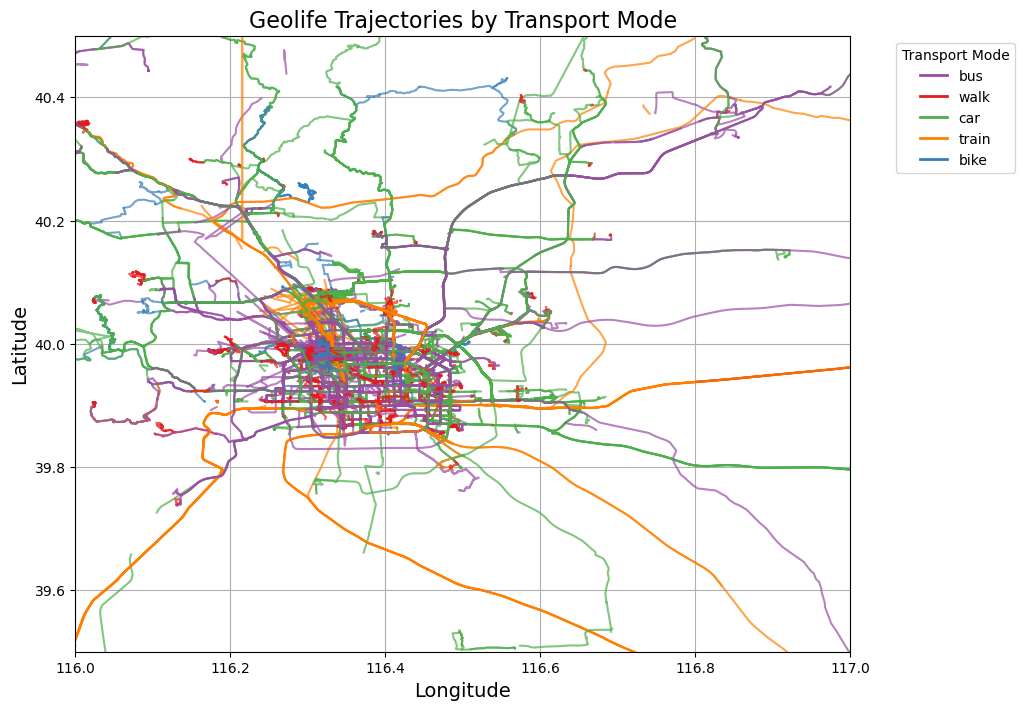

In [ ]:

color_palette = sns.color_palette("Set1", 8)

# Assign transport modes to colors
color_map = {
    'walk': color_palette[0],   # Soft Green
    'bike': color_palette[1],   # Light Orange
    'car': color_palette[2],    # Light Blue
    'bus': color_palette[3],    # Light Purple
    'train': color_palette[4],  # Teal
    'unknown': 'gray'           # Default for missing labels
}
plt.figure(figsize=(10, 8))
plt.title("Geolife Trajectories by Transport Mode", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116, 117)  # Longitude limits
plt.ylim(39.5, 40.5)  # Latitude limits

# Track unique transport modes for legend
unique_labels = set()

# Iterate over each segment and plot it with the corresponding color
for name, group in segment:
    transport_mode = group['label'].iloc[0]  # Take the first label for the segment
    color = color_map.get(transport_mode, 'black')  # Default to black if label is unknown
    plt.plot(group['lon'], group['lat'], color=color, alpha=0.7)
    unique_labels.add(transport_mode)  # Collect unique transport modes for legend

# Create a custom legend with unique transport modes
handles = [plt.Line2D([0], [0], color=color_map[label], lw=2) for label in unique_labels]
plt.legend(handles, unique_labels, title="Transport Mode", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.grid()

# Save the plot
plt.savefig("Graphs/geolife_trajectories_colored.png", dpi=1000, bbox_inches="tight")

# Show the plot
plt.show()

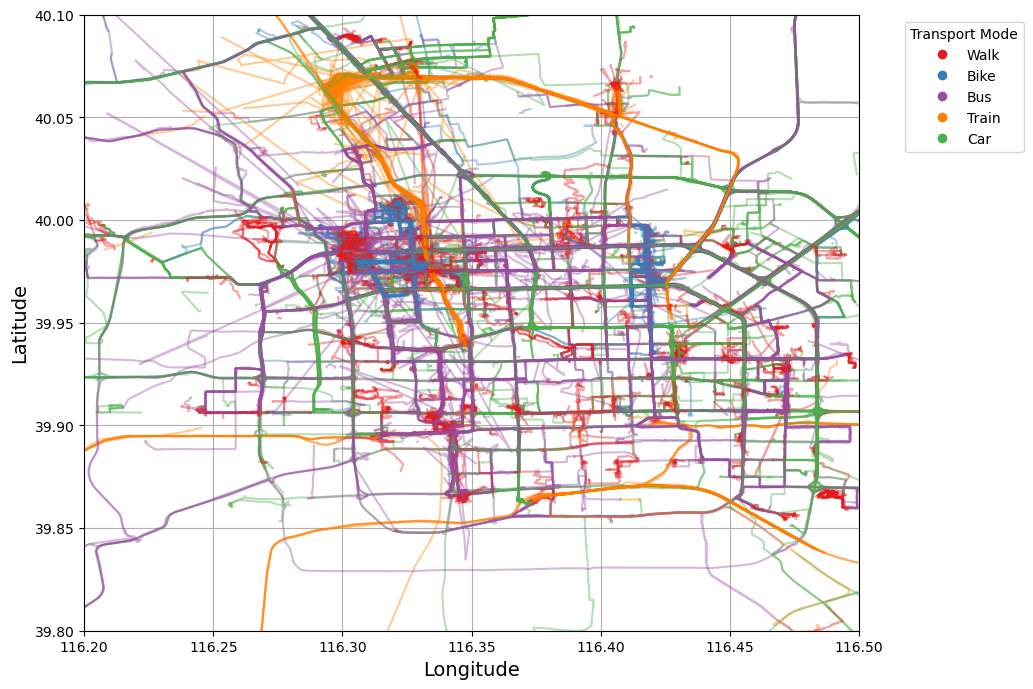

In [ ]:
# Get Seaborn's Set2 palette (8 colors)
color_palette = sns.color_palette("Set1", 8)

# Assign transport modes to colors
color_map = {
    'walk': color_palette[0],   # Soft Green
    'bike': color_palette[1],   # Light Orange
    'car': color_palette[2],    # Light Blue
    'bus': color_palette[3],    # Light Purple
    'train': color_palette[4],  # Teal
    '0': color_palette[5]         # Default for missing labels
}
plt.figure(figsize=(10, 8))
#plt.title("Geolife Trajectories by Transport Mode", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116.2, 116.5)  # Longitude limits
plt.ylim(39.8, 40.1)  # Latitude limits

# Track unique transport modes for legend
unique_labels = set()

# Iterate over each segment and plot it with the corresponding color
for name, group in segment:
    transport_mode = group['label'].iloc[0]  # Take the first label for the segment
    color = color_map.get(transport_mode, 'black')  # Default to black if label is unknown
    plt.plot(group['lon'], group['lat'],color=color, alpha=0.4)
    unique_labels.add(transport_mode)  # Collect unique transport modes for legend

# Create a custom legend with label replacements
handles = []
labels = []
for label in unique_labels:
    # Replace '0' with "Unlabeled" in legend
    display_label = "Unlabeled" if str(label) == '0' else str(label).capitalize()
    handles.append(plt.Line2D([0], [0], 
                    color=color_map.get(str(label), 'gray'), 
                    lw=2,
                    marker='o',
                    linestyle='None'))
    labels.append(display_label)

plt.legend(handles, labels, 
           title="Transport Mode", 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           fontsize=10)

#plt.tight_layout()
plt.grid()

# Save the plot
plt.savefig("Graphs/geolife_trajectories_colored_zoom_nofilter.png", dpi=500, bbox_inches="tight")
#plt.savefig(save_path, dpi=600, format="png", bbox_inches="tight", transparent=True)
# Show the plot
plt.show()

Apply filter

In [ ]:
df = data_processing.calculations(df)

In [ ]:
df = data_processing.filter(df, 120, 0.25)

In [77]:
segment = df.groupby('segment')

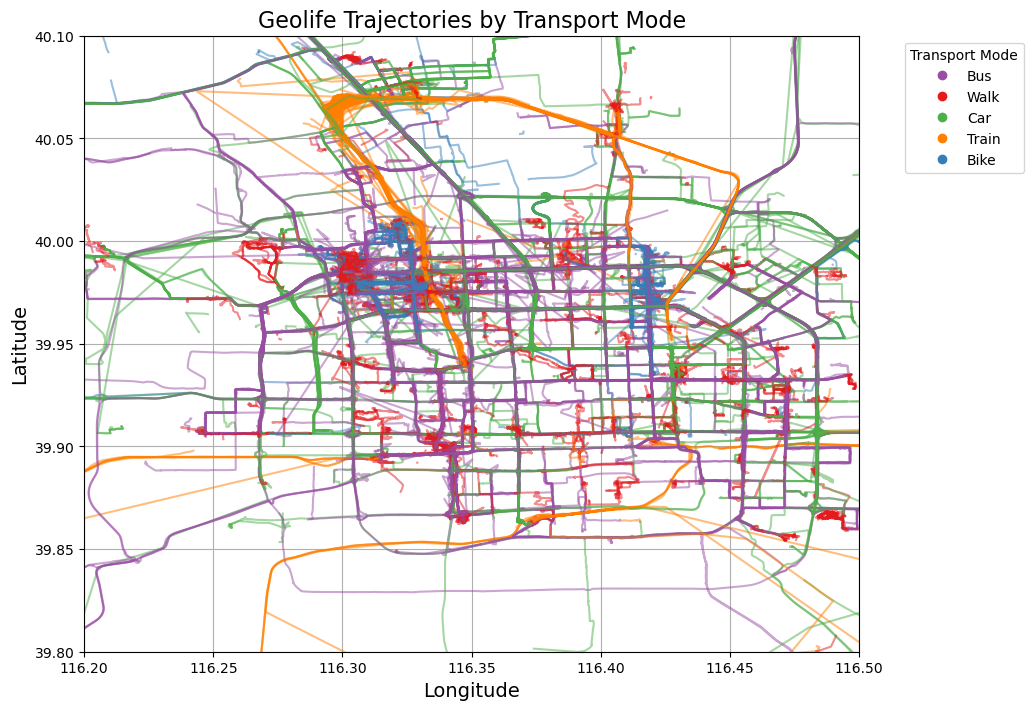

In [ ]:
# Get Seaborn's Set2 palette (8 colors)
color_palette = sns.color_palette("Set1", 8)

# Assign transport modes to colors
color_map = {
    'walk': color_palette[0],   # Soft Green
    'bike': color_palette[1],   # Light Orange
    'car': color_palette[2],    # Light Blue
    'bus': color_palette[3],    # Light Purple
    'train': color_palette[4],  # Teal
    '0': color_palette[5]         # Default for missing labels
}
plt.figure(figsize=(10, 8))
plt.title("Geolife Trajectories by Transport Mode", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.xlim(116.2, 116.5)  # Longitude limits
plt.ylim(39.8, 40.1)  # Latitude limits

# Track unique transport modes for legend
unique_labels = set()

# Iterate over each segment and plot it with the corresponding color
for name, group in segment:
    transport_mode = group['label'].iloc[0]  # Take the first label for the segment
    color = color_map.get(transport_mode, 'black')  # Default to black if label is unknown
    plt.plot(group['lon'], group['lat'],color=color, alpha=0.5)
    unique_labels.add(transport_mode)  # Collect unique transport modes for legend

# Create a custom legend with label replacements
handles = []
labels = []
for label in unique_labels:
    # Replace '0' with "Unlabeled" in legend
    display_label = "Unlabeled" if str(label) == '0' else str(label).capitalize()
    handles.append(plt.Line2D([0], [0], 
                    color=color_map.get(str(label), 'gray'), 
                    lw=2,
                    marker='o',
                    linestyle='None'))
    labels.append(display_label)

plt.legend(handles, labels, 
           title="Transport Mode", 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           fontsize=10)

#plt.tight_layout()
plt.grid()

# Save the plot
plt.savefig("Graphs/geolife_trajectories_colored_zoom.png", dpi=500, bbox_inches="tight")
#plt.savefig(save_path, dpi=600, format="png", bbox_inches="tight", transparent=True)
# Show the plot
plt.show()

# Single Trajectory

In [5]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)
df = data_processing.drop_unlabelled(df)
df = data_processing.create_segments(df)
df = data_processing.calculations(df)
df = data_processing.filter(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [71]:
# Filter rows where segment is 115 or 116
new_df = df[df['segment'].isin([14032, 14033])]

In [ ]:
new_df = new_df.iloc[2:]
new_df = new_df.reset_index(drop=True)

In [20]:
new_df

lat         lon    alt  elapsed time                time  \
1012062  39.909880  116.472143  232.9  39637.497419 2008-07-08 11:56:17   
1012063  39.910048  116.472207  232.9  39637.497442 2008-07-08 11:56:19   
1012064  39.910235  116.472225  232.9  39637.497465 2008-07-08 11:56:21   
1012065  39.910400  116.472225  232.9  39637.497488 2008-07-08 11:56:23   
1012066  39.910552  116.472220  232.9  39637.497512 2008-07-08 11:56:25   
...            ...         ...    ...           ...                 ...   
1012406  39.927425  116.470895  196.9  39637.507812 2008-07-08 12:11:15   
1012407  39.927443  116.470897  196.9  39637.507836 2008-07-08 12:11:17   
1012408  39.927443  116.470883  196.9  39637.507859 2008-07-08 12:11:19   
1012409  39.927462  116.470873  196.9  39637.507882 2008-07-08 12:11:21   
1012410  39.927468  116.470852  196.9  39637.507905 2008-07-08 12:11:23   

                 trajectory label  user  segment  distance      speed  \
1012062  20080708114909.plt   bus   153    14012  0.016374  29.473413   
1012063  20080708114909.plt   bus   153    14012  0.019488  35.078459   
1012064  20080708114909.plt   bus   153    14012  0.020808  37.454831   
1012065  20080708114909.plt   bus   153    14012  0.018347  33.024893   
1012066  20080708114909.plt   bus   153    14012  0.016874  30.372980   
...                     ...   ...   ...      ...       ...        ...   
1012406  20080708114909.plt  walk   153    14013  0.003805   6.848925   
1012407  20080708114909.plt  walk   153    14013  0.002051   3.692008   
1012408  20080708114909.plt  walk   153    14013  0.001134   2.041381   
1012409  20080708114909.plt  walk   153    14013  0.002206   3.971354   
1012410  20080708114909.plt  walk   153    14013  0.001995   3.590500   

         time_diff  acceleration      jerk     bearing  heading_change  \
1012062        2.0     -2.112840  3.485614   21.930669       12.783112   
1012063        2.0      2.802523  2.457681   16.083750        5.846919   
1012064        2.0      1.188186 -0.807168    4.325404       11.758346   
1012065        2.0     -2.214969 -1.701578    0.000000        4.325404   
1012066        2.0     -1.325956  0.444506  358.522822        1.477178   
...            ...           ...       ...         ...             ...   
1012406        2.0     -0.369921  0.400705  330.901914        0.850725   
1012407        2.0     -1.578458 -0.604269    4.052691       33.150776   
1012408        2.0     -0.825314  0.376572  270.000004       94.052686   
1012409        2.0      0.964987  0.895150  337.263983       67.263979   
1012410        2.0     -0.190427 -0.577707  291.930938       45.333045   

            Vrate  angular_velocity  angular_acceleration  
1012062  0.143373          6.391556             -2.119727  
1012063  0.159786          2.923459             -1.734048  
1012064  0.063446          5.879173              1.477857  
1012065  0.134139          2.162702             -1.858236  
1012066  0.087312          0.738589             -0.712056  
...           ...               ...                   ...  
1012406  0.108023          0.425363             -0.033840  
1012407  0.855068         16.575388              8.075013  
1012408  0.808584         47.026343             15.225477  
1012409  0.485974         33.631989             -6.697177  
1012410  0.106073         22.666523             -5.482733  

[346 rows x 19 columns]

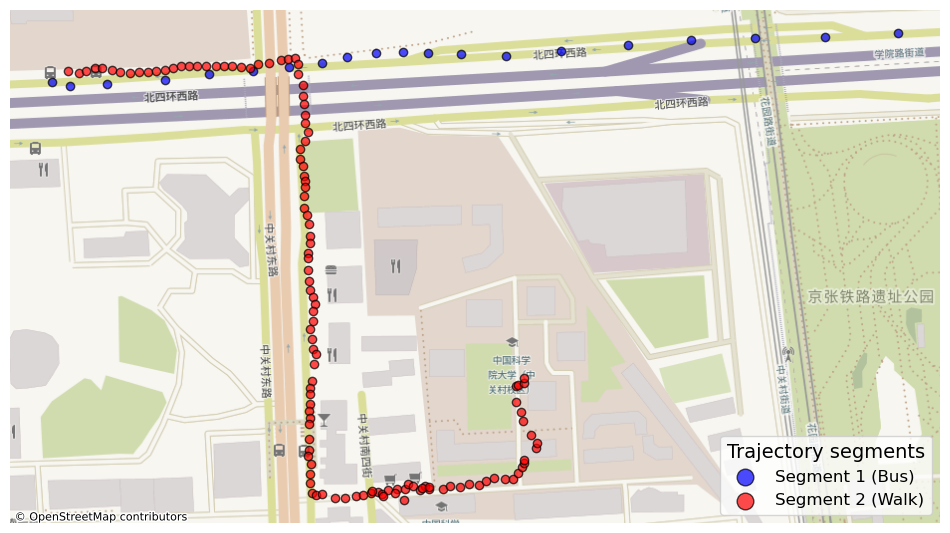

In [ ]:
# Get the Set1 color palette
color_palette = sns.color_palette("Set1", 8)

# Convert coordinates
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
new_df['x'], new_df['y'] = transformer.transform(
    new_df['lon'].values, 
    new_df['lat'].values
)

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Assign colors and labels
colors = {14032: 'blue', 14033: 'red'}
labels = {14032: 'Segment 1 (Bus)', 14033: 'Segment 2 (Walk)'}  # New label mapping

# Plot data
for segment, group in new_df.groupby('segment'):
    ax.scatter(
        group['x'], 
        group['y'], 
        color=colors[segment], 
        label=labels[segment],  # Use custom label
        alpha=0.7, 
        edgecolor='k'
    )

# Add basemap
ctx.add_basemap(
    ax,
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    attribution="© OpenStreetMap contributors"
)

# Customize plot
ax.set_axis_off()
ax.set_aspect("equal")
plt.legend(title='Trajectory segments', loc='lower right',    fontsize=12,          # Larger label text
    title_fontsize=14,    # Larger title text
    markerscale=2,        # Larger legend markers
    frameon=True,         # Show legend background
    framealpha=0.8 )  # Changed position and title
plt.savefig("Graphs/segmenttrajectorychangepoint.png", dpi=500, bbox_inches="tight")
plt.show()

Pie Chart

Graph saved to: Graphs/pie_chart.png


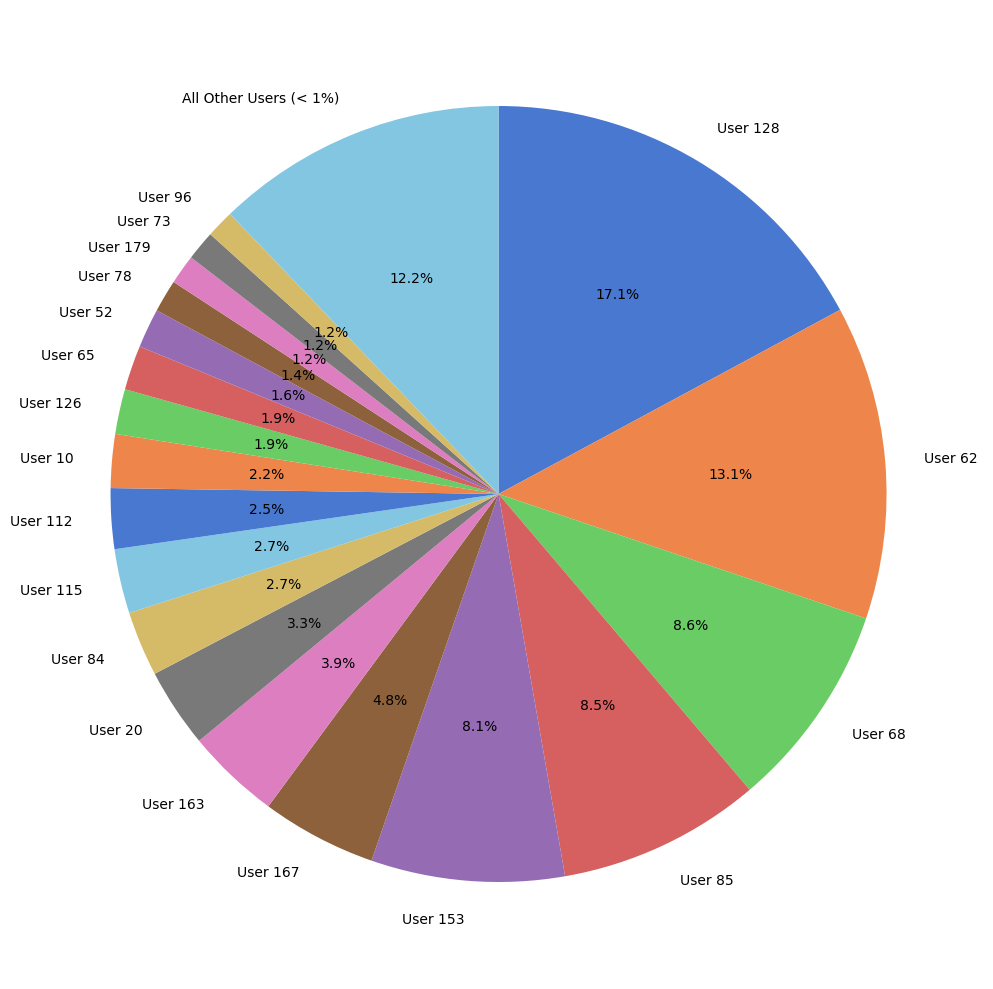

In [ ]:
user_unique_trajectories = df.groupby('user')['trajectory'].nunique()
user_unique_trajectories_sorted = user_unique_trajectories.sort_values(ascending=False)

threshold_percentage = 1.0
total_unique_trajectories = user_unique_trajectories_sorted.sum()
threshold_value = (threshold_percentage / 100.0) * total_unique_trajectories
large_slices = user_unique_trajectories_sorted[user_unique_trajectories_sorted >= threshold_value]
small_slices = user_unique_trajectories_sorted[user_unique_trajectories_sorted < threshold_value]
other_label = 'All Other Users (< 1%)'
if not small_slices.empty:
    other_count = small_slices.sum()
    plot_data = pd.concat([large_slices, pd.Series({other_label: other_count})])
    grouping_occurred = True
else:
    plot_data = user_unique_trajectories_sorted
    grouping_occurred = False


formatted_labels = []
for label in plot_data.index:
    if label == other_label:
        formatted_labels.append(label)
    else:
        formatted_labels.append(f"User {label}")


palette_name = "muted"
colors = sns.color_palette(palette_name, n_colors=len(plot_data))
plt.figure(figsize=(12, 10))
plt.pie(plot_data,
        labels=formatted_labels,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
        colors=colors
       )
title_str = f'Unique Trajectories per User ({palette_name.capitalize()} Palette)'
if grouping_occurred:
    title_str += f'\n(Users contributing < {threshold_percentage}% grouped as "{other_label}")'
else:
    title_str += f'\n(All users >= {threshold_percentage}%)'
#plt.title(title_str)
plt.tight_layout()

save_path = f"Graphs/pie_chart.png"

plt.savefig(save_path, dpi=500, bbox_inches='tight') 

plt.show()